In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%matplotlib inline

import itertools
import pandas
import csv
import torch
import numpy as np
from matplotlib import pyplot as plt

from awesome_glue.task import Task
from awesome_glue.utils import AttackMetric
from awesome_glue.config import Config

from luna import ram_write, chunks
from allennlpx import allenutil
from sklearn.manifold import TSNE

from adjustText import adjust_text
from luna import ram_read

from allennlpx.interpret.attackers.embedding_searcher import EmbeddingSearcher
from allennlpx import allenutil
from allennlp.data import Token

from collections import Counter, defaultdict
from tqdm import tqdm

from allennlpx.interpret.attackers.bruteforce import BruteForce
from allennlpx.interpret.attackers.attacker import DEFAULT_IGNORE_TOKENS
from luna import cast_list

import faiss
from copy import deepcopy

I0224 09:02:44.130957 139911811000128 file_utils.py:38] PyTorch version 1.2.0 available.
I0224 09:02:45.292024 139911811000128 modeling.py:230] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I0224 09:02:45.538643 139911811000128 modeling_bert.py:243] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
Loading faiss with AVX2 support.


In [3]:
config = Config()
task = Task(config) # type: Task
task.from_pretrained()
config

cache for SST-spacy exists
*** load SST-spacy from cache cost 2.74 seconds
cache for 2f2a46e51336b27a7262689b00016955 exists
*** load 2f2a46e51336b27a7262689b00016955 from cache cost 0.0331 seconds
Restore model from checkpoint saved/models/SST-lstm-glove@0.ckpt.


Basic Args:
	--task_id=SST
	--finetunable=True
	--arch=lstm
	--pretrain=glove
	--mode=train
	--augment_data=
	--given_model_name=
	--attack_vectors=glove
	--attack_data_split=dev
	--attack_size=400
	--attack_tsv=nogit/SST-bert.attack.tsv
	--alchemist=False
	--seed=2
Deduced Args:
	--model_name=SST-lstm-glove
	--tokenizer=spacy

In [49]:
attacker = BruteForce(task.predictor)
attacker.initialize()

In [50]:
attacker.embed_searcher.show_embedding_info('cos')

*** Statistics of parameters and 2-norm ***
[INFO] Param Mean -0.0150 Std 0.3718 Max 2.3890
[INFO] Norm Mean 6.4003 Std 0.7632 Max 9.6212
*** Statistics of distances in a N-nearest neighbourhood ***
    N    mean    std
-----  ------  -----
    5    0.42   0.14
   10    0.45   0.14
   20    0.49   0.14
   50    0.53   0.13
  100    0.57   0.13
  200    0.60   0.13
  500    0.64   0.13
10000    0.84   0.11
20000    0.91   0.13
*** Statistics of distances in a N-nearest neighbourhood ***
    when randomly moving by different step sizes
          Step      D-5  I-5      D-10  I-10      D-20  I-20      D-50  I-50      D-100  I-100
--  ----  ------  -----  -----  ------  ------  ------  ------  ------  ------  -------  -------
 1  0.46  90.8%    0.49  93.0%    0.52  93.0%     0.56  92.4%     0.59  92.9%      0.66  93.4%
 2  0.48  82.0%    0.51  85.4%    0.54  86.0%     0.58  85.4%     0.61  85.8%      0.68  86.9%
 5  0.57  64.8%    0.60  61.6%    0.62  63.0%     0.66  64.4%     0.68  65.3% 

the acting , costumes , music , cinematography and sound are missing astounding given the production 's austere locales .
the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .
1
tensor(0.4167, device='cuda:0') tensor(0.0641, device='cuda:0') tensor(0.4905, device='cuda:0')


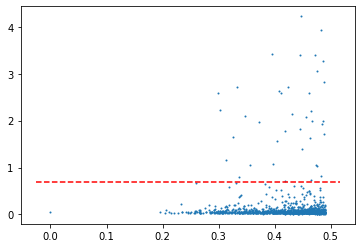

In [63]:
raw_instance = task.dev_data[2]

sent = allenutil.as_sentence(raw_instance)

label = raw_instance['label'].label

# task.reader.text_to_instance(sent)
# task.model.forward_on_instance(task.dev_data[0])

topk = 1000

pos_words = [line.rstrip('\n') for line in open("sentiment-words/positive-words.txt")]
neg_words = [line.rstrip('\n') for line in open("sentiment-words/negative-words.txt")]
not_words = [line.rstrip('\n') for line in open("sentiment-words/negation-words.txt")]
forbidden_words = pos_words + neg_words + not_words + DEFAULT_IGNORE_TOKENS
        
result = attacker.attack_from_json({"sent": sent},
                                    field_to_change='sent',
                                    ignore_tokens=forbidden_words,
                                    forbidden_tokens=forbidden_words,
                                    max_change_num=1,
                                    topk=topk,
                                    search_num=512)

print(allenutil.as_sentence(result['att']))
print(allenutil.as_sentence(result['raw']))
print(result['success'])

diff_idx = -1
while True:
    diff_idx += 1
    if result['att'][diff_idx] != result['raw'][diff_idx]:
        break

vals, idxs = attacker.embed_searcher.find_neighbours(result['raw'][diff_idx], 'cos', topk)
print(vals.mean(), vals.std(), vals.max())

nn_embs = attacker.embed_searcher.embed[idxs]
vals = cast_list(vals)
idxs = cast_list(idxs)
words = [task.vocab.get_token_from_index(idx) for idx in cast_list(idxs)]

instances = []
for i in range(topk):
    att_instance = deepcopy(raw_instance)
    att_instance['sent'].tokens[diff_idx] = Token(words[i])
    att_instance.indexed = False
    instances.append(att_instance)
    
# instances[0]['label'].label
# task.model.forward_on_instances(instances)
results = attacker.predictor._model.forward_on_instances(instances)
# attacker.predictor.predictions_to_labeled_instances(instances, results)
losses = []
for result in results:
    losses.append(- np.log(result['probs'])[label])
losses

nn_embs_2d = TSNE(n_components=2).fit_transform(nn_embs.detach().cpu().numpy())
from matplotlib import pyplot as plt
plt.scatter(vals, losses, s=1)
plt.hlines(-np.log(0.5), *plt.xlim(), colors='r', linestyles='dashed')

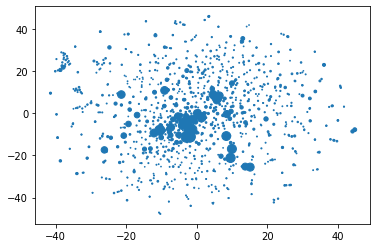

In [65]:
plt.scatter(nn_embs_2d[:,0], nn_embs_2d[:,1], s=np.array(losses)*30)

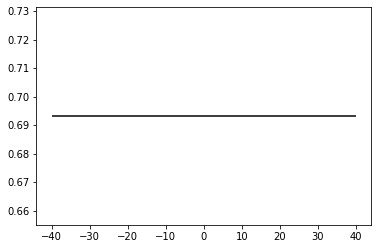